In [1]:
from PIL import Image
from collections import Counter
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


#### Q: Temos que separar o video por secçoes de tempo? ou basta separar por frames que se inserem em cada cluster?

## Análise do Debate **Chega-BE**

In [2]:
video = 'chega-be'
data = pd.read_pickle(os.path.join('processed', video + '.pkl'))
num_objects = []
type_objects = []
idx_bottle = -1
idx_laptop = -1
ppl_counter_list = []
ppl_counter = 0
fer_point_list = []
object_counter = []
frame_objects = []
for i in range(data.shape[0]):
    detections = data.iloc[i]['detections']
    num_objects.append(len(detections))
    for detection in detections:
        frame_objects.append(detection[4])
        if detection[4] == 'person':
            ppl_counter += 1
        if detection[4] == 'bottle':
            idx_bottle = i
        if detection[4] == 'laptop':
            idx_laptop = i
    ppl_counter_list.append(ppl_counter)
        
frame_object_counter = Counter(frame_objects)
object_counter.append(frame_object_counter)   

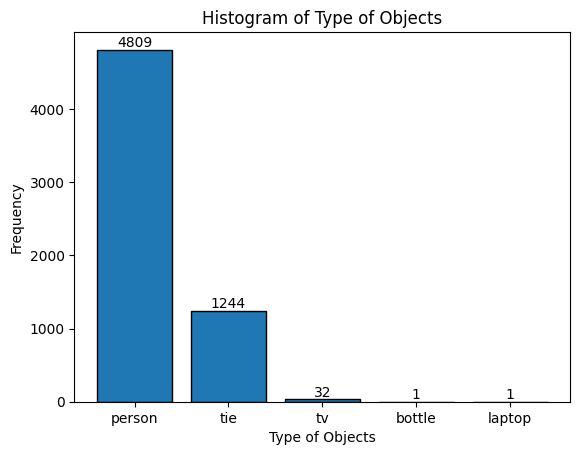

In [3]:
objects = object_counter[0].keys()
counts = object_counter[0].values()

plt.bar(objects, counts, edgecolor='black')

plt.title("Histogram of Type of Objects")
plt.xlabel("Type of Objects")
plt.ylabel("Frequency")
plt.yticks(range(0, 5000, 1000))

# Add frequency labels
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

#### Deteção errada de um objeto

In [4]:
frame_id = data.iloc[idx_laptop]['filename']
pimg = Image.open(os.path.join('processed', video, frame_id))
plt.imshow(pimg)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'processed\\chega-be\\img01885.jpeg'

## Análise por Debate


In [6]:
# Get a list of all .pkl files in the current directory
files = os.listdir('processed')
debates = [os.path.splitext(file)[0] for file in files]
print(debates)
# Create a dictionary to store the data
data = {}
for debate in debates:
    data[debate] = pd.read_pickle('processed/' + debate + '.pkl')
    data[debate] = data[debate].sort_values(by='filename', ascending=True)

['ad-be', 'ad-be', 'ad-cdu', 'ad-cdu', 'ad-chega', 'ad-chega', 'ad-il', 'ad-il', 'ad-livre', 'ad-livre', 'ad-pan', 'ad-pan', 'ad-ps', 'ad-ps', 'be-ps', 'cdu-be', 'cdu-be', 'cdu-ps', 'chega-be', 'chega-cdu', 'chega-cdu', 'chega-il', 'chega-il', 'chega-ps', 'il-be', 'il-be', 'il-cdu', 'il-cdu', 'il-ps', 'il-ps', 'livre-be', 'livre-be', 'livre-cdu', 'livre-cdu', 'livre-chega', 'livre-il', 'livre-ps', 'livre-ps', 'pan-be', 'pan-be', 'pan-cdu', 'pan-cdu', 'pan-chega', 'pan-chega', 'pan-il', 'pan-il', 'pan-livre', 'pan-livre', 'pan-ps']


#### Determinamos todos os objetos e emoções detetados pelos modelos

In [7]:
columns_ordered = ['Neutral', 'Anger', 'Fear', 'Surprise', 'Disgust', 'Sadness', 'Contempt', 'Happiness']
debate_emotions_dict = {}
emotions_names = []
objects_names = []

for key, df in data.items():
    emotion_counter = []
    debate_emotions_processed = []
    for i in range(df.shape[0]):
        faces = df.iloc[i]['fer']
        frame_emotions = []
        for face in faces:
            fer_point = [0,0]
            fer_point[0] = (face['location'][0] + face['location'][1]) / 2
            fer_point[1] = (face['location'][2] + face['location'][3]) / 2
            if face['emotion'] not in emotions_names:
                emotions_names.append(face['emotion'])
            if not (fer_point[0] >= 1050 and fer_point[0] <= 1250 and fer_point[1] >= 500 and fer_point[1] <= 600):
                frame_emotions.append(face['emotion'])
        objects = df.iloc[i]['detections']    
        for object in objects:
            if object[4] not in objects_names:
                objects_names.append(object[4])
                
        frame_emotion_counter = Counter(frame_emotions)    
        emotion_counter.append(frame_emotion_counter)
    
    emotions_df = pd.DataFrame(emotion_counter)
    emotions_df = emotions_df.reindex(columns=columns_ordered)
    emotions_df['group'] = emotions_df.index // 300

    grouped = emotions_df.groupby('group').sum()
    grouped = grouped.div(grouped.sum(axis=1), axis=0)
    
    debate_emotions_dict[key] = grouped
print(emotions_names)
print(objects_names)

['Contempt', 'Disgust', 'Surprise', 'Happiness', 'Neutral', 'Sadness', 'Anger', 'Fear']
['person', 'dining table', 'chair', 'tie', 'toilet', 'dog', 'tv', 'train', 'wine glass', 'bottle', 'sink', 'laptop', 'bowl', 'umbrella', 'book', 'boat', 'surfboard', 'cell phone', 'handbag', 'skis', 'cup', 'remote', 'toothbrush', 'refrigerator', 'banana', 'skateboard', 'bed', 'suitcase', 'oven', 'horse', 'parking meter', 'scissors']


#### Caracterização do Dataset

In [7]:
#Informação sobre o dataset
df = data['ad-be']
print(df.info())

print(20*'-')
print('Detections column')
col = df['detections'].apply(np.shape)
print(col.head(3))
print('Each vector represents an object detected and it has 6 elements: x, y, width, height, object class, confidence')
print(20*'-')

print('Poses column')
col = df['poses'].apply(np.shape)
print(col.head(3))
print('Each vector represents a pose detected and has 33 elements, each composed by 5 elements: x, y, z, visibility, presence')
print(20*'-')

print('Faces column')
col = df['faces'].apply(np.shape)
print(col.head(3))
print(20*'-')

print('Text column')
print('Represents the text detected in the image')
print(20*'-')

print('Embedding column')
col = df['embedding'].apply(np.shape)
print(col.head(3))
print(20*'-')

print('Fer column')
col = df['fer'].apply(np.shape)
print(col.head(3))
print('Each vector represents a face detected and has 1 dictionary with the following attributes:')
for key, value in df['fer'][0][0].items():
    if key == 'emotion':
        print(f"The value for key '{key}' is 1 of 8 emotions")
    else:
        print(f"The size of the value for key '{key}' is {len(value)}")

<class 'pandas.core.frame.DataFrame'>
Index: 2060 entries, 1253 to 677
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    2060 non-null   object
 1   detections  2060 non-null   object
 2   poses       2060 non-null   object
 3   faces       2060 non-null   object
 4   text        2060 non-null   object
 5   embedding   2060 non-null   object
 6   fer         2060 non-null   object
dtypes: object(7)
memory usage: 128.8+ KB
None
--------------------
Detections column
1253    (1, 6)
968     (1, 6)
1840    (1, 6)
Name: detections, dtype: object
Each vector represents an object detected and it has 6 elements: x, y, width, height, object class, confidence
--------------------
Poses column
1253    (1, 33, 5)
968     (1, 33, 5)
1840    (1, 33, 5)
Name: poses, dtype: object
Each vector represents a pose detected and has 33 elements, each composed by 5 elements: x, y, z, visibility, presence
--------------------
Faces

#### Distribuição das emoções ao longo do tempo (secções de 5 minutos cada)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


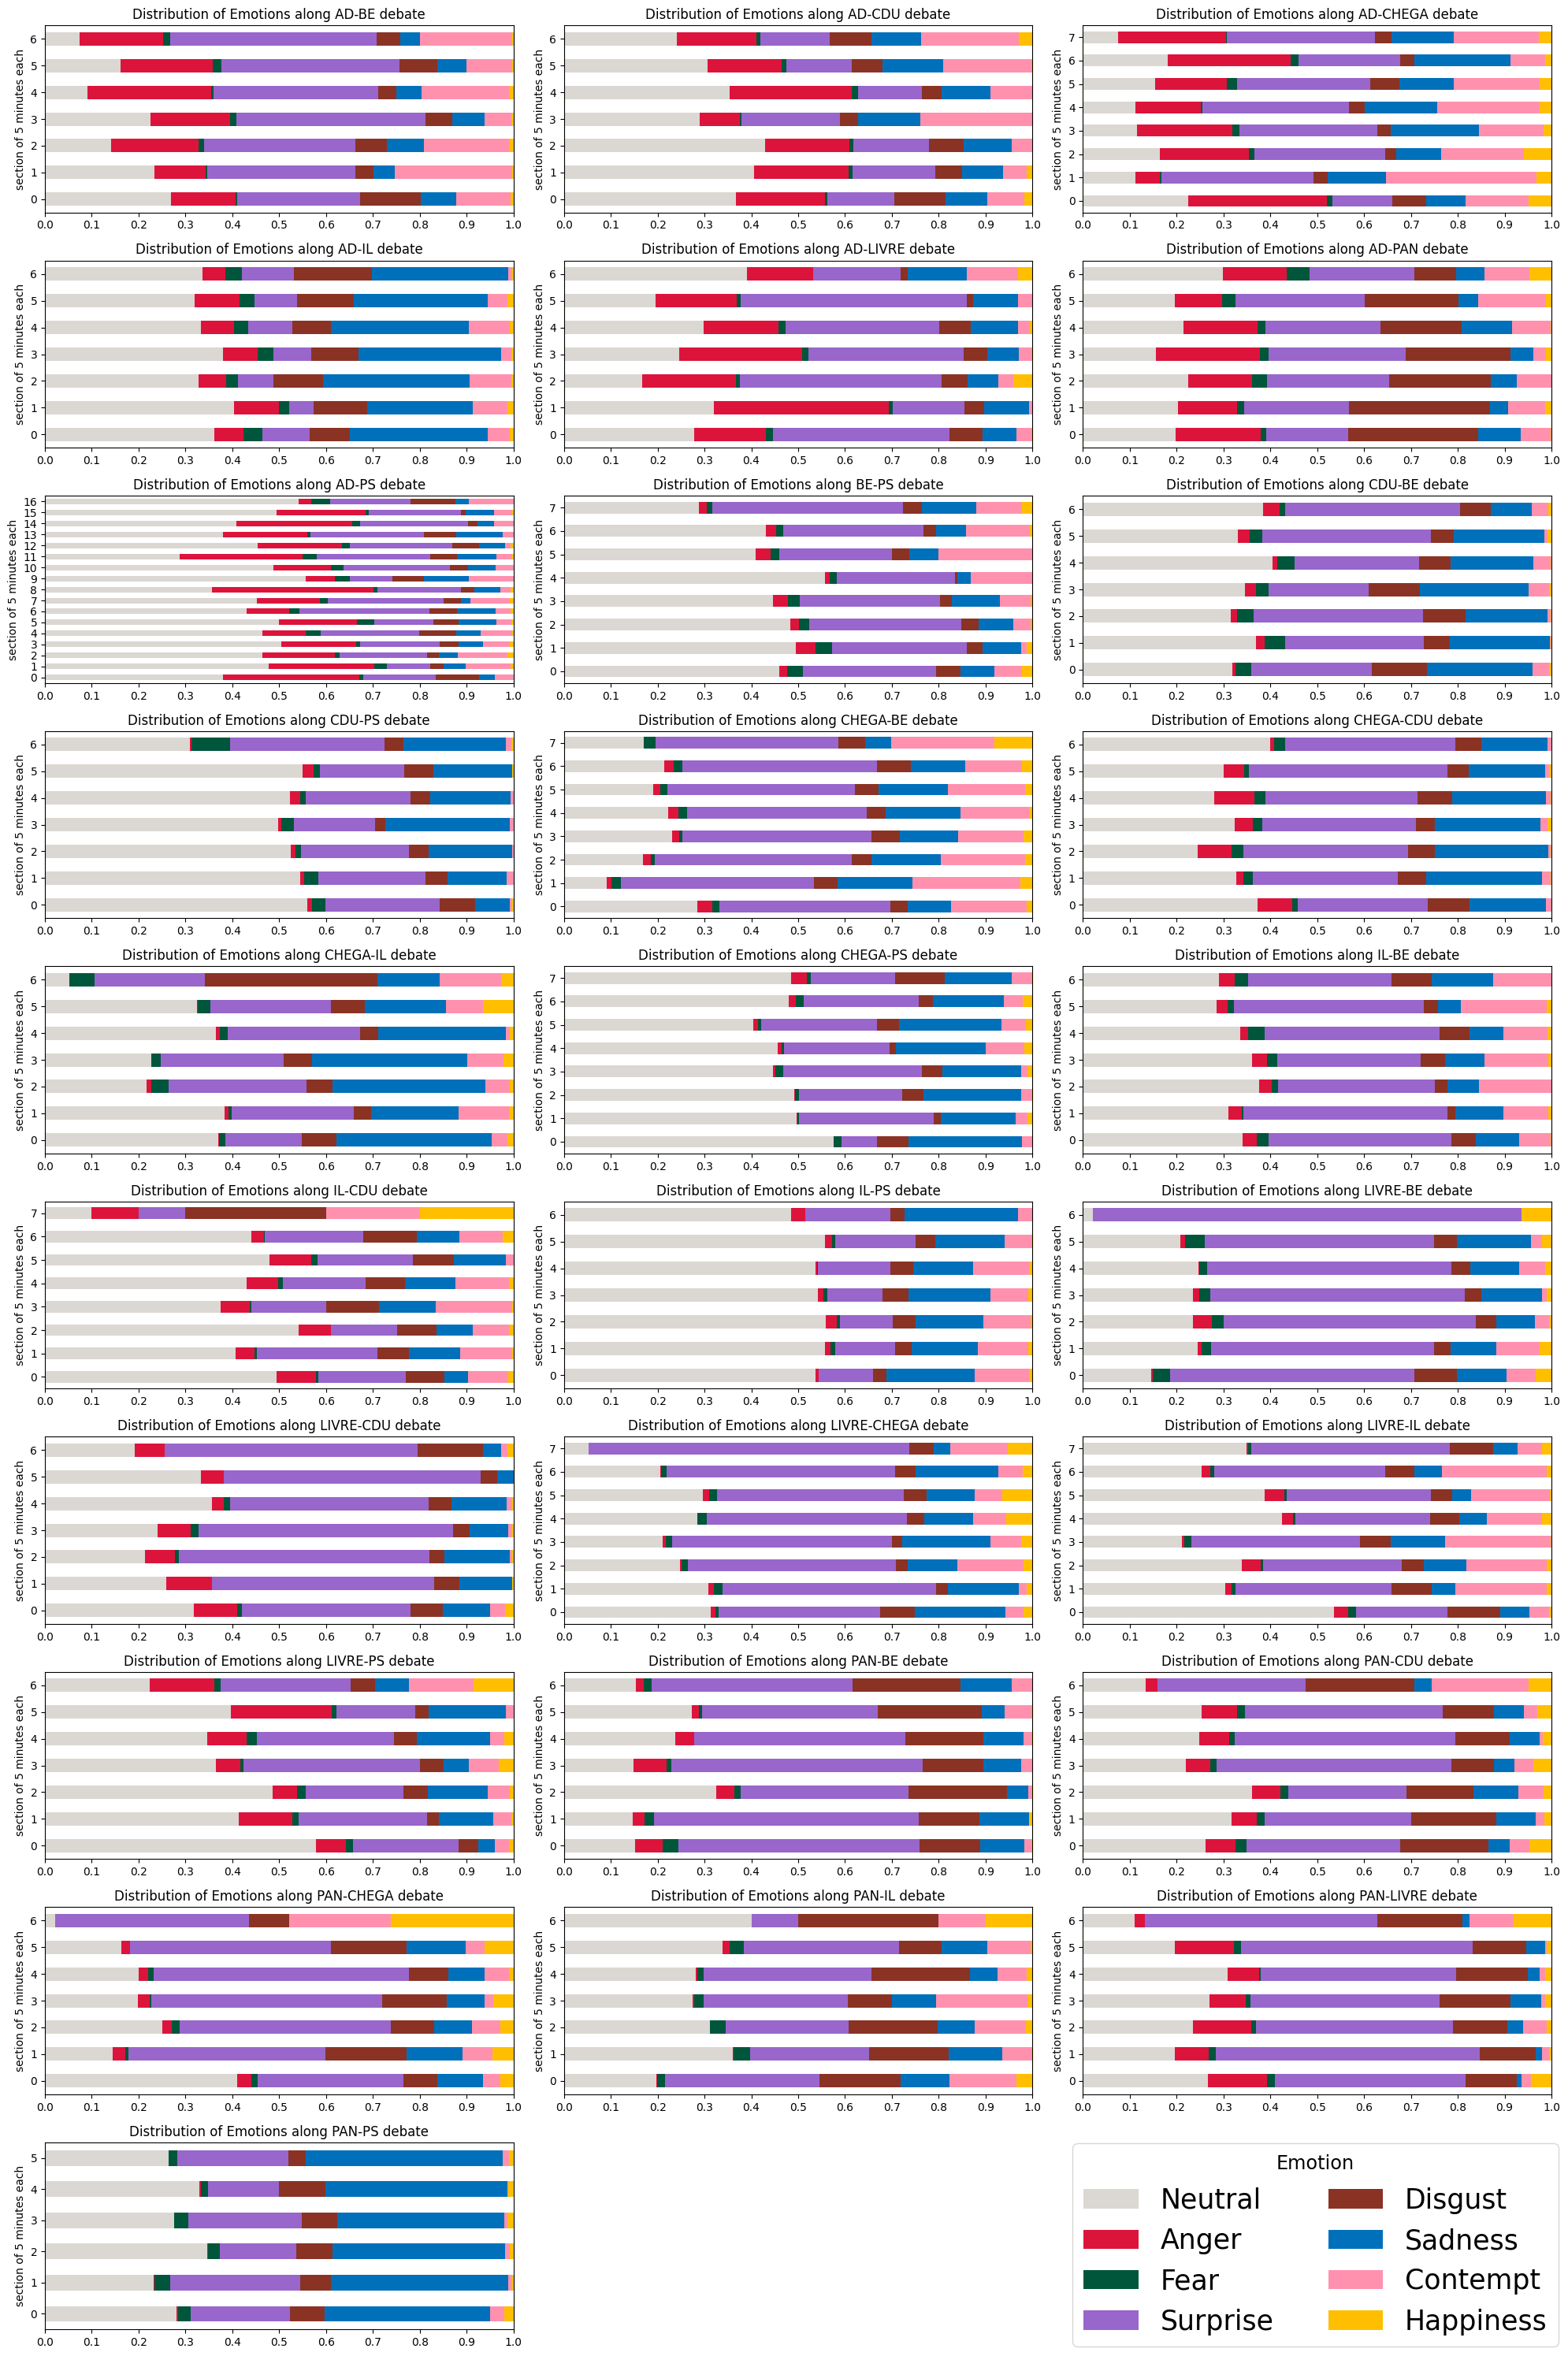

In [8]:
fig, axs = plt.subplots(10, 3, figsize=(20, 30))  # Create a 14x2 grid of subplots
axs = axs.ravel()  # Flatten the array of axes

colors = ['#DBD7D2', '#DC143C', '#00563B', '#9966CC', '#8A3324', '#0070BB', '#FF91AF', '#FFBF00']

for i, (key, df) in enumerate(debate_emotions_dict.items()):
    df.plot(kind='barh', stacked=True, color=colors, ax=axs[i])  # Plot on the i-th subplot
    axs[i].set_title('Distribution of Emotions along {key} debate'.format(key=key.upper(), weight='bold'))
    axs[i].set_ylabel("section of 5 minutes each")
    axs[i].set_xticks(np.arange(0, 1.1, 0.1))
    axs[i].set_xlim(0, 1)

# Remove the legend from each subplot
for ax in axs:
    ax.legend().set_visible(False)

# Hide the subplots where there's no data being plotted
for i in range(len(debate_emotions_dict), len(axs)):
    axs[i].set_visible(False)

# Create a single legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', title='Emotion', title_fontsize='xx-large', bbox_to_anchor=(0.5, 0., 0.5, 0.5), prop={'size': 25}, ncols=2)

plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

## Análise por Partido

In [85]:
# Get a list of all .pkl files in the current directory
files = os.listdir('processed')

# Initialize an empty DataFrame for each party
df_dict = {
    'chega': pd.DataFrame(),
    'livre': pd.DataFrame(),
    'ad': pd.DataFrame(),
    'cdu': pd.DataFrame(),
    'be': pd.DataFrame(),
    'ps': pd.DataFrame(),
    'il': pd.DataFrame(),
    'pan': pd.DataFrame()
}
parties = list(df_dict.keys())
for party in parties:
    # Filter the list to include only files with 'name' in their filename
    party_files = [file for file in files if party in file and file.endswith('.pkl')]

    # Loop over the list of files
    for file in party_files:
        # Read the .pkl file into a DataFrame
        data = pd.read_pickle(os.path.join('processed', file))
        data['debate'] = 
        # Append the data to the corresponding DataFrame
        data = data.sort_values(by='filename', ascending=True)
        df_dict[party] = pd.concat([df_dict[party], data], ignore_index=True)

In [10]:
ppl_counter_list = []
ppl_counter = 0
all_emotions = []
all_fer_center = []
all_objects_types = []
all_objects_types_processed = []
all_objects_center = []
all_emotions_processed = []

for key, df in df_dict.items():
    party_fer_center = []
    party_objects_center = []
    party_emotions = []
    party_objects_types = []
    party_objects_types_processed = []
    party_emotions_processed = []
    for i in range(df.shape[0]):
        detections = df.iloc[i]['detections']
        for detection in detections:
            party_objects_types.append(detection[4])
            if detection[5] >= 0.75:    # Only consider objects with a confidence level of 75% or higher
                party_objects_types_processed.append(detection[4])
            if detection[4] == 'person':
                ppl_counter += 1
                point = [0,0]
                point[0] = detection[0] + detection[2] / 2
                point[1] = detection[1] + detection[3] / 2
                party_objects_center.append(point)
            if detection[4] == 'laptop':
                idx_laptop = i
        ppl_counter_list.append(ppl_counter)
        ppl_counter = 0
        faces = df.iloc[i]['fer']
        for face in faces:
            fer_point = [0,0]
            fer_point[0] = (face['location'][0] + face['location'][1]) / 2
            fer_point[1] = (face['location'][2] + face['location'][3]) / 2
            party_fer_center.append(fer_point)
            party_emotions.append(face['emotion'])
            if not (fer_point[0] >= 1050 and fer_point[0] <= 1250 and fer_point[1] >= 500 and fer_point[1] <= 600):
                party_emotions_processed.append(face['emotion'])
                
    all_objects_center.append(party_objects_center)
    all_fer_center.append(party_fer_center)
    emotion_counter = Counter(party_emotions)    
    all_emotions.append(emotion_counter)
    emotion_processed_counter = Counter(party_emotions_processed)    
    all_emotions_processed.append(emotion_processed_counter)
    object_types_counter = Counter(party_objects_types)
    all_objects_types.append(object_types_counter)
    object_types_processed_counter = Counter(party_objects_types_processed)
    all_objects_types_processed.append(object_types_processed_counter)

all_emotions = pd.DataFrame(all_emotions)
all_emotions_normalized = all_emotions.div(all_emotions.sum(axis=1), axis=0)
all_emotions_normalized.index = parties
columns_ordered = ['Neutral', 'Anger', 'Fear', 'Surprise', 'Disgust', 'Sadness', 'Contempt', 'Happiness']
all_emotions_normalized = all_emotions_normalized.reindex(columns=columns_ordered)


all_emotions_processed = pd.DataFrame(all_emotions_processed)
all_emotions_processed_normalized = all_emotions_processed.div(all_emotions_processed.sum(axis=1), axis=0)
all_emotions_processed_normalized.index = parties
all_emotions_processed_normalized = all_emotions_processed_normalized.reindex(columns=columns_ordered)

all_objects_types = pd.DataFrame(all_objects_types)
all_objects_types_normalized = all_objects_types.div(all_objects_types.sum(axis=1), axis=0)
all_objects_types_normalized.index = parties

all_objects_types_processed = pd.DataFrame(all_objects_types_processed)
all_objects_types_processed_normalized = all_objects_types_processed.div(all_objects_types_processed.sum(axis=1), axis=0)
all_objects_types_processed_normalized.index = parties

#### Análise da distribuição de emoções e tipo de objetos detetados por Partido interveniente no debate

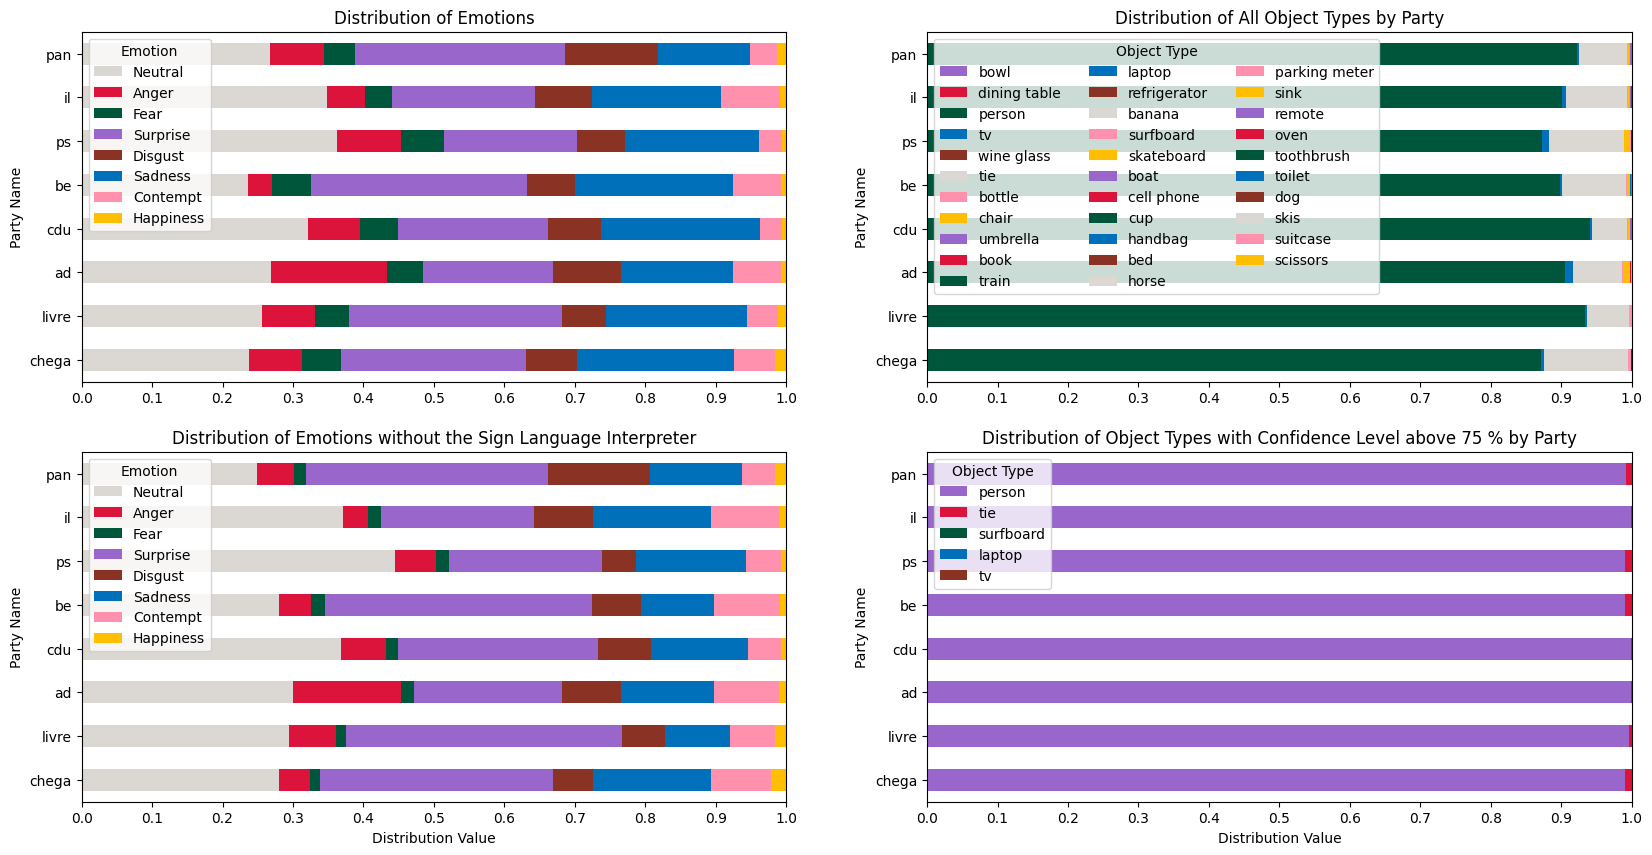

In [11]:
# Create a figure and a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(20, 10))  # Adjust the figsize as needed
colors = ['#DBD7D2', '#DC143C', '#00563B', '#9966CC', '#8A3324', '#0070BB', '#FF91AF', '#FFBF00']

# First plot
all_emotions_normalized.plot(kind='barh', stacked=True, color=colors, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Emotions')
axs[0, 0].set_ylabel('Party Name')
axs[0, 0].set_xticks(np.arange(0, 1.1, 0.1))
axs[0, 0].set_xlim(0, 1)
axs[0, 0].legend(loc='upper left', title='Emotion')

# Second plot
all_emotions_processed_normalized.plot(kind='barh', stacked=True, color=colors, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Emotions without the Sign Language Interpreter')
axs[1, 0].set_xlabel('Distribution Value')
axs[1, 0].set_ylabel('Party Name')
axs[1, 0].set_xticks(np.arange(0, 1.1, 0.1))
axs[1, 0].set_xlim(0, 1)
axs[1, 0].legend(loc='upper left', title='Emotion')

colors = ['#9966CC', '#DC143C', '#00563B', '#0070BB', '#8A3324', '#DBD7D2', '#FF91AF', '#FFBF00']
# Third plot
all_objects_types_normalized.plot(kind='barh', stacked=True, color=colors, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of All Object Types by Party')
axs[0, 1].set_ylabel('Party Name')
axs[0, 1].set_xticks(np.arange(0, 1.1, 0.1))
axs[0, 1].set_xlim(0, 1)
axs[0, 1].legend(loc='upper left', ncols = 3, title='Object Type')

# Fourth plot
all_objects_types_processed_normalized.plot(kind='barh', stacked=True, color=colors, ax=axs[1, 1])
axs[1, 1].set_title('Distribution of Object Types with Confidence Level above 75 % by Party')
axs[1, 1].set_xlabel('Distribution Value')
axs[1, 1].set_ylabel('Party Name')
axs[1, 1].set_xticks(np.arange(0, 1.1, 0.1))
axs[1, 1].set_xlim(0, 1)
axs[1, 1].legend(loc='upper left', title='Object Type')

plt.show()

#### Gráfico dos centros das caixas de deteção de objetos e caras

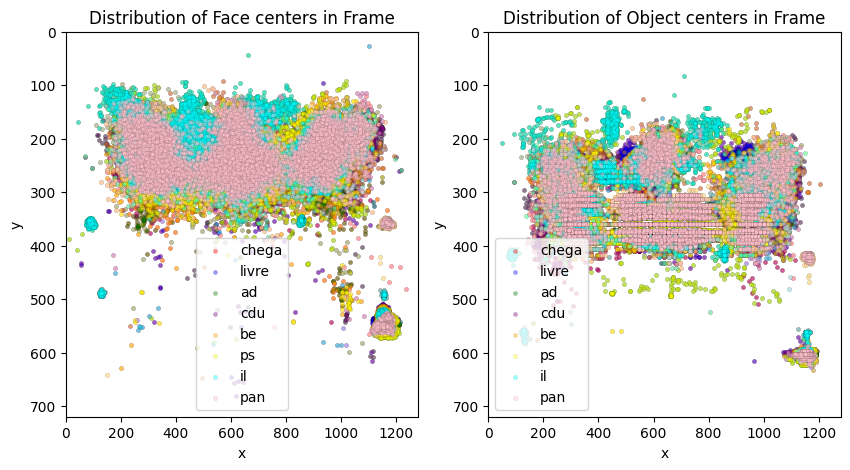

In [12]:
# Unpack the point_list into two lists: x and y
colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan', 'pink']

# Create a figure and a 1x2 subplot grid
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i in range(len(all_fer_center)):
    x, y = zip(*all_fer_center[i])
    axs[0].scatter(x, y, linewidths=0.1, edgecolors='black', alpha=0.4, s=10, c=colors[i])


axs[0].set_title('Distribution of Face centers in Frame')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_xticks(range(0, 1280, 200))
axs[0].set_yticks(range(0, 720, 100))
axs[0].set_xlim(0, 1280)
axs[0].set_ylim(0, 720)
axs[0].invert_yaxis()
axs[0].legend(parties)

for i in range(len(all_objects_center)):
    x, y = zip(*all_objects_center[i])
    axs[1].scatter(x, y, linewidths=0.1, edgecolors='black', alpha=0.4, s=10, c=colors[i])
    
axs[1].set_title('Distribution of Object centers in Frame')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_xticks(range(0, 1280, 200))
axs[1].set_yticks(range(0, 720, 100))
axs[1].set_xlim(0, 1280)
axs[1].set_ylim(0, 720)
axs[1].invert_yaxis()
axs[1].legend(parties)

plt.show()

# Clustering

(5709, 128)

 Total Variance Explained: 99.36


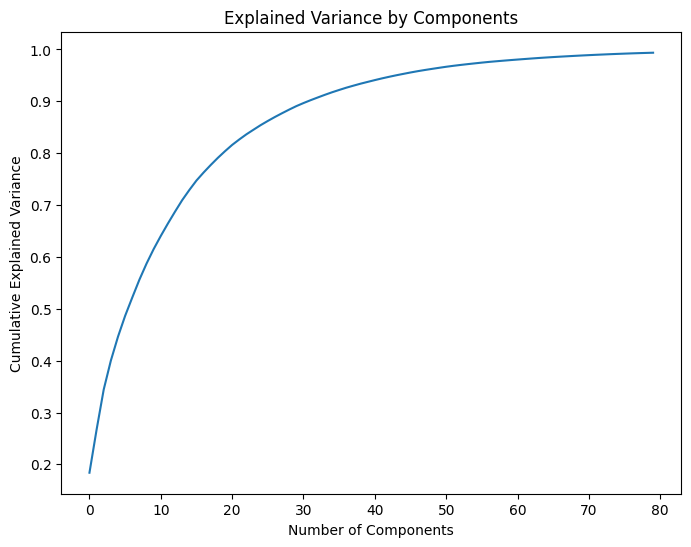

In [7]:
# Standardize the features
data['embeddings'] = data['fer'].apply(lambda lst: [d['embedding'] for d in lst if 'embedding' in d])
all_embeddings = []
for embeddings in data['embeddings']:
    all_embeddings.extend(embeddings)
all_embeddings = np.array(all_embeddings)
print(all_embeddings.shape)
X = StandardScaler().fit_transform(all_embeddings)
# Instantiate PCA
pca = PCA(n_components=80)
# Fit PCA to features
principalComponents = pca.fit_transform(X)

#print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(range(len(cumulative_variance)), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

In [49]:
mariana_files = ['img00052.jpeg', 'img01333.jpeg', 'img01399.jpeg']
ventura_files = ['img00296.jpeg', 'img00570.jpeg', 'img00789.jpeg']
mariana_idx = [data.loc[data['filename'] == value].index[0] for value in mariana_files]
ventura_idx = [data.loc[data['filename'] == value].index[0] for value in ventura_files]

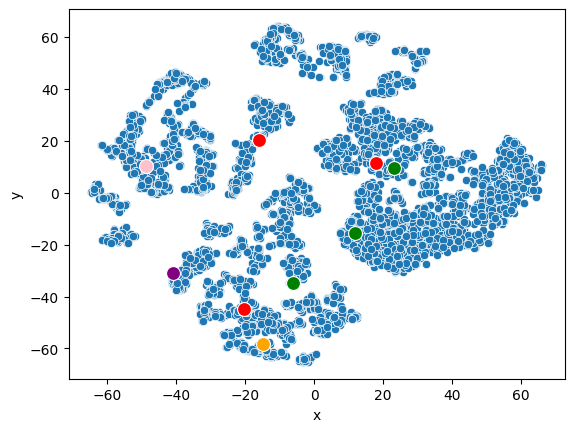

In [53]:
m = TSNE(learning_rate=50)
tsne_features = m.fit_transform(principalComponents)
df = pd.DataFrame()
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]

sns.scatterplot(x='x', y='y', data=df)
sns.scatterplot(x='x', y='y', data=df.iloc[mariana_idx], color='red', s=100)
sns.scatterplot(x='x', y='y', data=df.iloc[ventura_idx], color='green', s=100)
idx = data.loc[data['filename'] == 'img01444.jpeg'].index[0]   # 2 speakers in frame
sns.scatterplot(x='x', y='y', data=df.iloc[[idx]], color='pink', s=100)
idx = data.loc[data['filename'] == 'img00005.jpeg'].index[0] # moderator only
sns.scatterplot(x='x', y='y', data=df.iloc[[idx]], color='orange', s=100)
idx = data.loc[data['filename'] == 'img00001.jpeg'].index[0]    # 3 people in frame
sns.scatterplot(x='x', y='y', data=df.iloc[[idx]], color='purple', s=100)
idx = data.loc[data['filename'] == 'img00116.jpeg'].index[0]
plt.show()

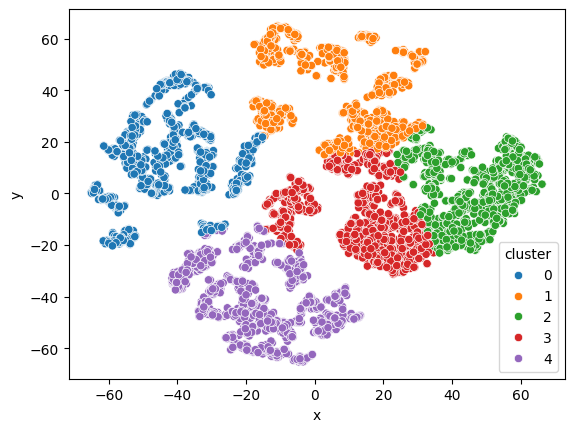

In [51]:
kmeans = KMeans(n_clusters=5, init='random', random_state=42)
kmeans.fit(df[['x', 'y']])

# Get the cluster assignments for each data point
df['cluster'] = kmeans.labels_

# Plot the clusters
sns.scatterplot(x='x', y='y', hue='cluster', data=df, palette='tab10')
df['filename'] = data['filename']
df = df.sort_values(by='filename', ascending=True)
plt.show()

(2204, 1024)

 Total Variance Explained: 99.37


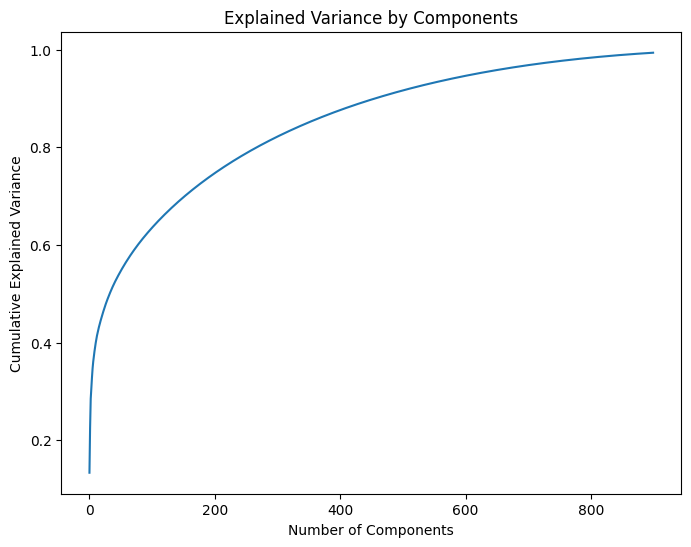

In [26]:
all_embedding = []
for embeddings in data['embedding']:
    all_embedding.append(embeddings)
all_embedding = np.array(all_embedding)
print(all_embedding.shape)
X = StandardScaler().fit_transform(all_embedding)
# Instantiate PCA
pca = PCA(n_components=900)
# Fit PCA to features
principalComponents = pca.fit_transform(X)

#print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(range(len(cumulative_variance)), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

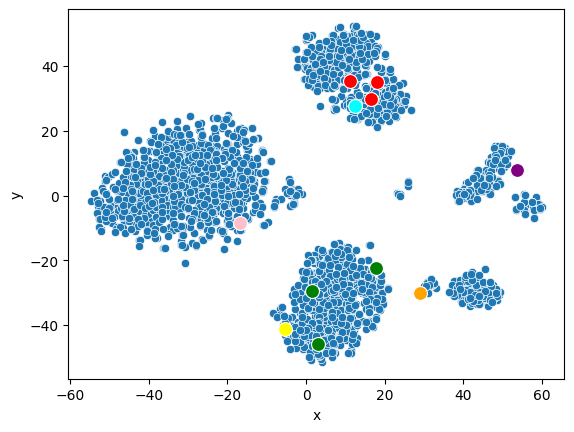

In [27]:
m = TSNE(learning_rate=50)
tsne_features = m.fit_transform(principalComponents)
df = pd.DataFrame()
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
sns.scatterplot(x='x', y='y', data=df)
sns.scatterplot(x='x', y='y', data=df.iloc[mariana_idx], color='red', s=100)
sns.scatterplot(x='x', y='y', data=df.iloc[ventura_idx], color='green', s=100)
idx = data.loc[data['filename'] == 'img01444.jpeg'].index[0]   # 2 speakers in frame
sns.scatterplot(x='x', y='y', data=df.iloc[[idx]], color='pink', s=100)
idx = data.loc[data['filename'] == 'img00005.jpeg'].index[0] # moderator only
sns.scatterplot(x='x', y='y', data=df.iloc[[idx]], color='orange', s=100)
idx = data.loc[data['filename'] == 'img00001.jpeg'].index[0]    # 3 people in frame
sns.scatterplot(x='x', y='y', data=df.iloc[[idx]], color='purple', s=100)
idx = data.loc[data['filename'] == 'img00116.jpeg'].index[0]
plt.show()

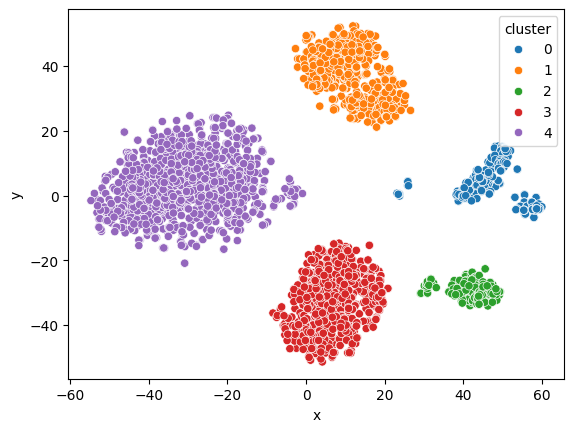

In [46]:
kmeans = KMeans(n_clusters=5, init='random', random_state=42)
kmeans.fit(df[['x', 'y']])

# Get the cluster assignments for each data point
df['cluster'] = kmeans.labels_

# Plot the clusters
sns.scatterplot(x='x', y='y', hue='cluster', data=df, palette='tab10')
df['filename'] = data['filename']
df = df.sort_values(by='filename', ascending=True)
plt.show()

In [34]:
labels = {0: '3 pessoas no frame', 1: 'Mariana Mortágua', 2: 'moderador', 3: 'André Ventura', 4: '2 pessoas no frame'}
df['cluster_label'] = df['cluster'].map(labels)
df.head(30)

,x,y,cluster,cluster_label,filename
1350,53.826897,8.030713,0,3 pessoas no frame,img00001.jpeg
1039,53.827972,8.028139,0,3 pessoas no frame,img00002.jpeg
1967,53.829979,8.046931,0,3 pessoas no frame,img00003.jpeg
1633,53.815495,8.158479,0,3 pessoas no frame,img00004.jpeg
286,29.162395,-30.237507,2,moderador,img00005.jpeg
1320,29.307667,-30.162493,2,moderador,img00006.jpeg
987,30.908516,-30.170303,2,moderador,img00007.jpeg
1196,30.972799,-30.113426,2,moderador,img00008.jpeg
115,30.951694,-28.669333,2,moderador,img00009.jpeg
873,30.134329,-27.857054,2,moderador,img00010.jpeg


(806864, 5)
Variance of each component: [0.34592343 0.33345701 0.32061957]

 Total Variance Explained: 100.0


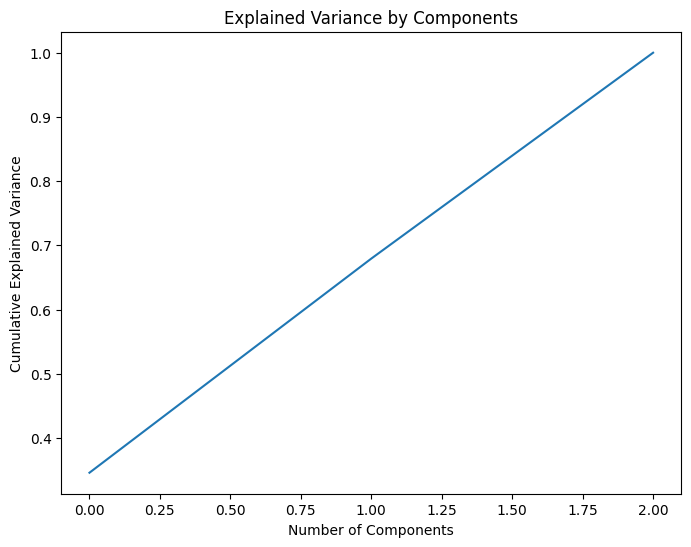

In [4]:
all_faces = []
for faces in data['faces']:
    reshaped_faces = np.array(faces).reshape(-1, 5)  # Reshape each vector to (478, 5)
    all_faces.append(reshaped_faces)
all_faces = np.concatenate(all_faces, axis=0)  # Concatenate all vectors along the first axis

print(all_faces.shape)
X = StandardScaler().fit_transform(all_faces)
# Instantiate PCA
pca = PCA(n_components=3)
# Fit PCA to features
principalComponents = pca.fit_transform(X)

print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(range(len(cumulative_variance)), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

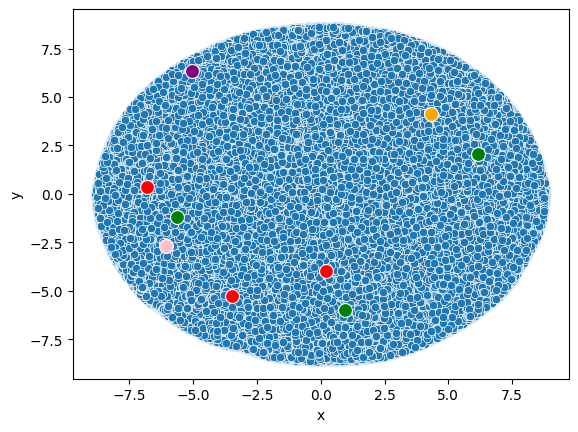

In [6]:
mariana_files = ['img00052.jpeg', 'img01333.jpeg', 'img01399.jpeg']
ventura_files = ['img00296.jpeg', 'img00570.jpeg', 'img00789.jpeg']
mariana_idx = [data.loc[data['filename'] == value].index[0] for value in mariana_files]
ventura_idx = [data.loc[data['filename'] == value].index[0] for value in ventura_files]

m = TSNE(learning_rate=50)
tsne_features = m.fit_transform(principalComponents)
df = pd.DataFrame()
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]

sns.scatterplot(x='x', y='y', data=df)
sns.scatterplot(x='x', y='y', data=df.iloc[mariana_idx], color='red', s=100)
sns.scatterplot(x='x', y='y', data=df.iloc[ventura_idx], color='green', s=100)
idx = data.loc[data['filename'] == 'img01444.jpeg'].index[0]   # 2 speakers in frame
sns.scatterplot(x='x', y='y', data=df.iloc[[idx]], color='pink', s=100)
idx = data.loc[data['filename'] == 'img00005.jpeg'].index[0] # moderator only
sns.scatterplot(x='x', y='y', data=df.iloc[[idx]], color='orange', s=100)
idx = data.loc[data['filename'] == 'img00001.jpeg'].index[0]    # 3 people in frame
sns.scatterplot(x='x', y='y', data=df.iloc[[idx]], color='purple', s=100)
idx = data.loc[data['filename'] == 'img00116.jpeg'].index[0]
plt.show()

In [6]:
from mpl_toolkits.mplot3d import Axes3D

m = TSNE(learning_rate=50)
tsne_features = m.fit_transform(principalComponents)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

df = pd.DataFrame()
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
df['z'] = tsne_features[:,2]

paulo_files = ['img00062.jpeg', 'img00096.jpeg', 'img00440.jpeg']
ventura_files = ['img00289.jpeg', 'img00544.jpeg', 'img00829.jpeg']
paulo_idx = [data.loc[data['filename'] == value].index[0] for value in paulo_files]
ventura_idx = [data.loc[data['filename'] == value].index[0] for value in ventura_files]

ax.scatter(df['x'], df['y'], df['z'])
ax.scatter(df.iloc[paulo_idx]['x'], df.iloc[paulo_idx]['y'], df.iloc[paulo_idx]['z'], color='red')
ax.scatter(df.iloc[ventura_idx]['x'], df.iloc[ventura_idx]['y'], df.iloc[ventura_idx]['z'], color='green')
idx = data.loc[data['filename'] == 'img00376.jpeg'].index[0]   # 2 speakers in frame
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], color='pink')
idx = data.loc[data['filename'] == 'img00060.jpeg'].index[0]   # speakers + moderator in frame
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], color='orange')
idx = data.loc[data['filename'] == 'img00001.jpeg'].index[0] # moderator only
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], color='purple')
idx = data.loc[data['filename'] == 'img00022.jpeg'].index[0]    # 3 people in frame
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], color='yellow')

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

df = pd.DataFrame()
df['x'] = principalComponents[:,0]
df['y'] = principalComponents[:,1]
df['z'] = principalComponents[:,2]

paulo_files = ['img00062.jpeg', 'img00096.jpeg', 'img00440.jpeg']
ventura_files = ['img00289.jpeg', 'img00544.jpeg', 'img00829.jpeg']
paulo_idx = [data.loc[data['filename'] == value].index[0] for value in paulo_files]
ventura_idx = [data.loc[data['filename'] == value].index[0] for value in ventura_files]

ax.scatter(df['x'], df['y'], df['z'])
ax.scatter(df.iloc[paulo_idx]['x'], df.iloc[paulo_idx]['y'], df.iloc[paulo_idx]['z'], color='red')
ax.scatter(df.iloc[ventura_idx]['x'], df.iloc[ventura_idx]['y'], df.iloc[ventura_idx]['z'], color='green')
idx = data.loc[data['filename'] == 'img00376.jpeg'].index[0]   # 2 speakers in frame
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], color='pink')
idx = data.loc[data['filename'] == 'img00060.jpeg'].index[0]   # speakers + moderator in frame
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], color='orange')
idx = data.loc[data['filename'] == 'img00001.jpeg'].index[0] # moderator only
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], color='purple')
idx = data.loc[data['filename'] == 'img00022.jpeg'].index[0]    # 3 people in frame
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], color='yellow')

plt.show()

(3011, 128)
Variance of each component: [0.14720572 0.12375609 0.09802917 0.06255198 0.05492618 0.05102164
 0.04510013 0.03714326 0.03281466 0.02961478 0.02762285 0.02421259
 0.02209015 0.01882848 0.0181312  0.01677612 0.01508445 0.01299788
 0.0127519  0.01101268 0.00979922 0.00940755 0.00888926 0.00762114
 0.00741085 0.00695871 0.00638352 0.00604754 0.0057735  0.00517687
 0.00501052 0.00455441 0.00434472 0.00389777 0.00346188 0.00317541
 0.00313635 0.00265151 0.00260289 0.0021352  0.0018949  0.00178859
 0.00165063 0.00158458 0.00154176 0.00132059 0.00124082 0.00108635
 0.00103288 0.00099064 0.00091554 0.00090576 0.00081074 0.00077747
 0.00071315 0.00068624 0.00062621 0.00061618 0.00058037 0.00052907]

 Total Variance Explained: 99.14


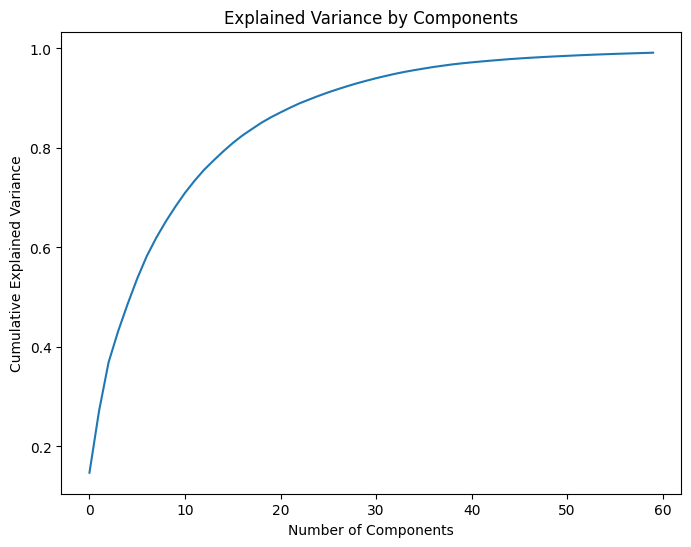

In [3]:
video = 'chega-cdu'
data = pd.read_pickle(os.path.join('processed', video + '.pkl'))
# Standardize the features
data['embeddings'] = data['fer'].apply(lambda lst: [d['embedding'] for d in lst if 'embedding' in d])
all_embeddings = []
for embeddings in data['embeddings']:
    all_embeddings.extend(embeddings)
all_embeddings = np.array(all_embeddings)
print(all_embeddings.shape)
X = StandardScaler().fit_transform(all_embeddings)
# Instantiate PCA
pca = PCA(n_components=60)
# Fit PCA to features
principalComponents = pca.fit_transform(X)

print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(range(len(cumulative_variance)), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

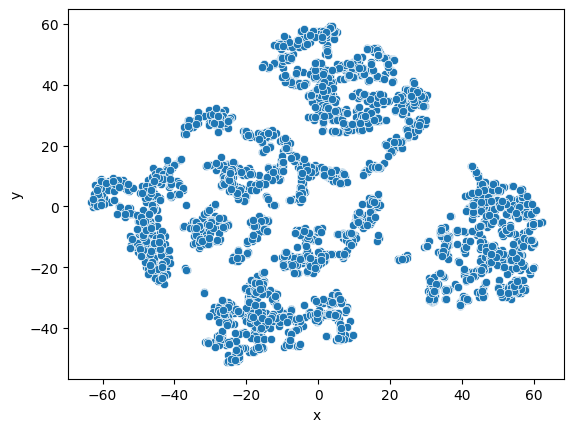

In [84]:
m = TSNE(learning_rate=50)
tsne_features = m.fit_transform(principalComponents)
df = pd.DataFrame()
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]

sns.scatterplot(x='x', y='y', data=df)
plt.show()

(1954, 1024)

 Total Variance Explained: 99.52


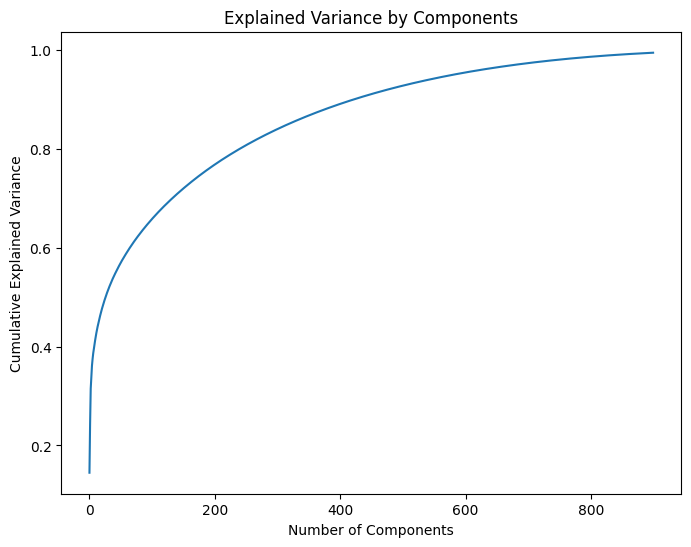

In [9]:
video = 'chega-cdu'
data = pd.read_pickle(os.path.join('processed', video + '.pkl'))
all_embedding = []
for embeddings in data['embedding']:
    all_embedding.append(embeddings)
all_embedding = np.array(all_embedding)
print(all_embedding.shape)
X = StandardScaler().fit_transform(all_embedding)
# Instantiate PCA
pca = PCA(n_components=900)
# Fit PCA to features
principalComponents = pca.fit_transform(X)

#print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(range(len(cumulative_variance)), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

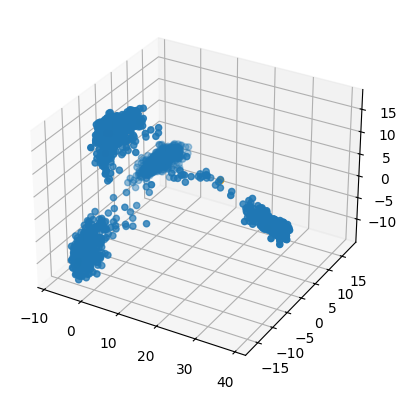

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

df = pd.DataFrame()
df['x'] = principalComponents[:,0]
df['y'] = principalComponents[:,1]
df['z'] = principalComponents[:,2]

paulo_files = ['img00062.jpeg', 'img00096.jpeg', 'img00440.jpeg']
ventura_files = ['img00289.jpeg', 'img00544.jpeg', 'img00829.jpeg']
paulo_idx = [data.loc[data['filename'] == value].index[0] for value in paulo_files]
ventura_idx = [data.loc[data['filename'] == value].index[0] for value in ventura_files]

ax.scatter(df['x'], df['y'], df['z'])
ax.scatter(df.iloc[paulo_idx]['x'], df.iloc[paulo_idx]['y'], df.iloc[paulo_idx]['z'], color='red')
ax.scatter(df.iloc[ventura_idx]['x'], df.iloc[ventura_idx]['y'], df.iloc[ventura_idx]['z'], color='green')
idx = data.loc[data['filename'] == 'img00376.jpeg'].index[0]   # 2 speakers in frame
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], color='pink')
idx = data.loc[data['filename'] == 'img00060.jpeg'].index[0]   # speakers + moderator in frame
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], color='orange')
idx = data.loc[data['filename'] == 'img00001.jpeg'].index[0] # moderator only
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], color='purple')
idx = data.loc[data['filename'] == 'img00022.jpeg'].index[0]    # 3 people in frame
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], color='yellow')

plt.show()

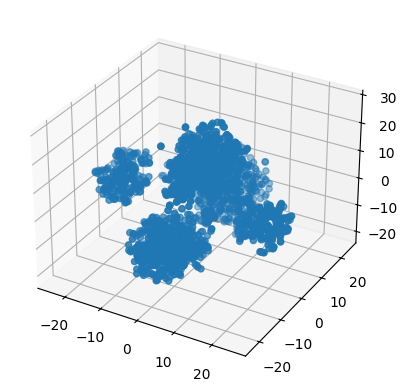

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

paulo_files = ['img00062.jpeg', 'img00096.jpeg', 'img00440.jpeg']
ventura_files = ['img00289.jpeg', 'img00544.jpeg', 'img00829.jpeg']
paulo_idx = [data.loc[data['filename'] == value].index[0] for value in paulo_files]
ventura_idx = [data.loc[data['filename'] == value].index[0] for value in ventura_files]

m = TSNE(learning_rate=50, n_components=3)
tsne_features = m.fit_transform(principalComponents)
df = pd.DataFrame()
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
df['z'] = tsne_features[:,2]

ax.scatter(df['x'], df['y'], df['z'])
ax.scatter(df.iloc[paulo_idx]['x'], df.iloc[paulo_idx]['y'], df.iloc[paulo_idx]['z'], c='r')
ax.scatter(df.iloc[ventura_idx]['x'], df.iloc[ventura_idx]['y'], df.iloc[ventura_idx]['z'], c='g')
idx = data.loc[data['filename'] == 'img00376.jpeg'].index[0]   # 2 speakers in frame
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], c='pink')
idx = data.loc[data['filename'] == 'img00060.jpeg'].index[0]   # speakers + moderator in frame
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], c='orange')
idx = data.loc[data['filename'] == 'img00001.jpeg'].index[0] # moderator only
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], c='purple')
idx = data.loc[data['filename'] == 'img00022.jpeg'].index[0]    # 3 people in frame
ax.scatter(df.iloc[[idx]]['x'], df.iloc[[idx]]['y'], df.iloc[[idx]]['z'], c='yellow')

plt.show()

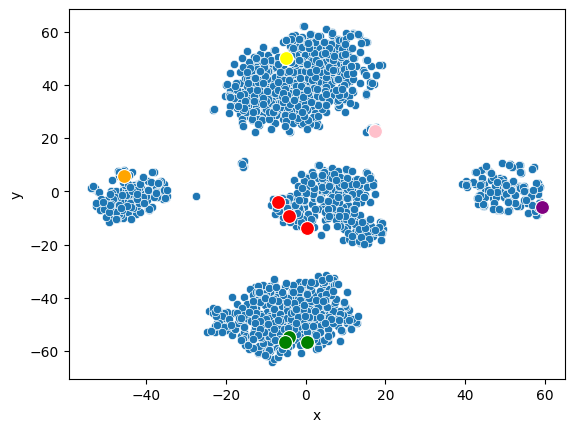

In [20]:
paulo_files = ['img00062.jpeg', 'img00096.jpeg', 'img00440.jpeg']
ventura_files = ['img00289.jpeg', 'img00544.jpeg', 'img00829.jpeg']
paulo_idx = [data.loc[data['filename'] == value].index[0] for value in paulo_files]
ventura_idx = [data.loc[data['filename'] == value].index[0] for value in ventura_files]

m = TSNE(learning_rate=50)
tsne_features = m.fit_transform(principalComponents)
df = pd.DataFrame()
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]

sns.scatterplot(x='x', y='y', data=df)
sns.scatterplot(x='x', y='y', data=df.iloc[paulo_idx], color='red', s=100)
sns.scatterplot(x='x', y='y', data=df.iloc[ventura_idx], color='green', s=100)
idx = data.loc[data['filename'] == 'img00060.jpeg'].index[0]   # speakers + moderator in frame
sns.scatterplot(x='x', y='y', data=df.iloc[[idx]], color='pink', s=100)
idx = data.loc[data['filename'] == 'img00376.jpeg'].index[0]   # 2 speakers in frame
sns.scatterplot(x='x', y='y', data=df.iloc[[idx]], color='yellow', s=100)
idx = data.loc[data['filename'] == 'img00001.jpeg'].index[0] # moderator only
sns.scatterplot(x='x', y='y', data=df.iloc[[idx]], color='orange', s=100)
idx = data.loc[data['filename'] == 'img00022.jpeg'].index[0]    # 3 people in frame
sns.scatterplot(x='x', y='y', data=df.iloc[[idx]], color='purple', s=100)
idx = data.loc[data['filename'] == 'img00116.jpeg'].index[0]
plt.show()

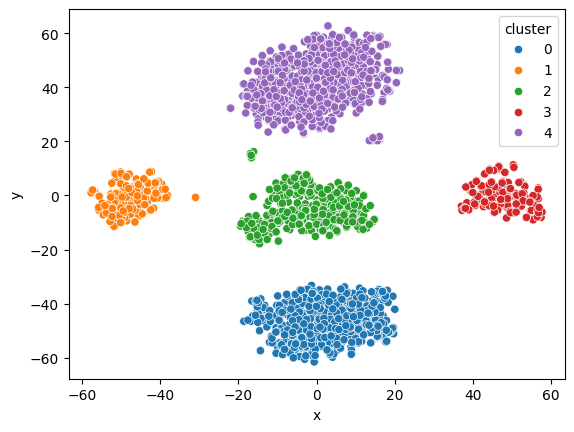

In [6]:
kmeans = KMeans(n_clusters=5, init='random', random_state=42)
kmeans.fit(df[['x', 'y']])

# Get the cluster assignments for each data point
df['cluster'] = kmeans.labels_

# Plot the clusters
sns.scatterplot(x='x', y='y', hue='cluster', data=df, palette='tab10')
df['filename'] = data['filename']
df = df.sort_values(by='filename', ascending=True)
plt.show()

In [7]:
import re
def extract_number(s):
    return int(re.search(r'\d+', s).group())

labels = {0: 'André Ventura', 1: 'moderador', 2: 'Paulo Raimundo', 3: '3 people in frame', 4: '2 people in frame'}
df['cluster_label'] = df['cluster'].map(labels)
df['cluster_change'] = (df['cluster_label'] != df['cluster_label'].shift()).cumsum()
df['file_number'] = df['filename'].apply(extract_number) - 1
df.reset_index(drop=True, inplace=True)
df.head(5)

,x,y,cluster,filename,cluster_label,cluster_change,file_number
0,-49.841454,7.341073,1,img00001.jpeg,moderador,1,0
1,-49.872639,7.428148,1,img00002.jpeg,moderador,1,1
2,-50.007549,8.154277,1,img00003.jpeg,moderador,1,2
3,-51.389595,7.912767,1,img00004.jpeg,moderador,1,3
4,-50.125088,8.661098,1,img00005.jpeg,moderador,1,4


In [8]:
# Create a mapping from 'cluster_change' to 'cluster_label'
cluster_mapping = df.drop_duplicates('cluster_change').set_index('cluster_change')['cluster_label'].to_dict()
# Group by 'cluster_change' and find the min and max 'file_number' for each group
file_intervals = df.groupby('cluster_change')['file_number'].agg(['min', 'max'])
video_df = pd.DataFrame()
video_df['start(s)'] = file_intervals['min'].astype(int)
video_df['end(s)'] = file_intervals['max'].astype(int)
video_df['start(min)'] = video_df['start(s)'].apply(lambda x: '{}:{:02d}'.format(*divmod(x, 60)))
video_df['end(min)'] = video_df['end(s)'].apply(lambda x: '{}:{:02d}'.format(*divmod(x, 60)))
video_df['duration'] = video_df['end(s)'] - video_df['start(s)']
# Use the mapping to create a new 'cluster_label' column
video_df['cluster_label'] = video_df.index.map(cluster_mapping)

video_df = video_df.reset_index(drop=True)
video_df = video_df.sort_values(by='start(s)', ascending=True)
video_df.head(30)

,start(s),end(s),start(min),end(min),duration,cluster_label
0,0,14,0:00,0:14,14,moderador
1,15,15,0:15,0:15,0,Paulo Raimundo
2,16,17,0:16,0:17,1,André Ventura
3,18,20,0:18,0:20,2,moderador
4,21,26,0:21,0:26,5,3 people in frame
5,27,30,0:27,0:30,3,Paulo Raimundo
6,31,33,0:31,0:33,2,moderador
7,34,34,0:34,0:34,0,Paulo Raimundo
8,35,36,0:35,0:36,1,André Ventura
9,37,38,0:37,0:38,1,Paulo Raimundo


# Análise por Partido

In [16]:
# Get a list of all .pkl files in the current directory
files = os.listdir('processed')

# Initialize an empty DataFrame for each party
df_dict = {
    'chega': pd.DataFrame(),
    'livre': pd.DataFrame(),
    'ad': pd.DataFrame(),
    'cdu': pd.DataFrame(),
    'be': pd.DataFrame(),
    'ps': pd.DataFrame(),
    'il': pd.DataFrame(),
    'pan': pd.DataFrame()
}
parties = list(df_dict.keys())
for party in parties:
    # Filter the list to include only files with 'name' in their filename
    party_files = [file for file in files if party in file and file.endswith('.pkl')]

    # Loop over the list of files
    for file in party_files:
        # Read the .pkl file into a DataFrame
        data = pd.read_pickle(os.path.join('processed', file))
        data['debate'] = os.path.splitext(file)[0]
        # Append the data to the corresponding DataFrame
        data = data.sort_values(by='filename', ascending=True)
        df_dict[party] = pd.concat([df_dict[party], data], ignore_index=True)


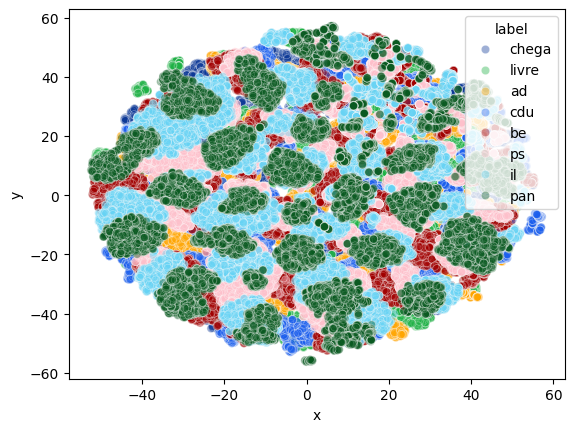

In [14]:
palette = {"chega": "#0D3997", "be": "#A10000", "cdu": "#1C5FED", "il": "#67D3F4", "ps": "pink", "pan": "#0A5A21", "livre": "#1EB145", "ad": "orange"}
# Assuming 'parties' is a list of your DataFrames, and 'party_names' is a list of the corresponding party names
for key, data in df_dict.items():
    # Perform PCA
    pca = PCA(n_components=70)
    all_embedding = []
    for embeddings in data['embedding']:
        all_embedding.append(embeddings)
    all_embedding = np.array(all_embedding)
    X = StandardScaler().fit_transform(all_embedding)
    pca_result = pca.fit_transform(X)

    # Perform t-SNE
    tsne = TSNE(learning_rate=50)
    tsne_results = tsne.fit_transform(pca_result)

    # Create DataFrame for seaborn
    df = pd.DataFrame()
    df['x'] = tsne_results[:, 0]
    df['y'] = tsne_results[:, 1]
    df['label'] = key
    # Create scatter plot
    sns.scatterplot(x='x', y='y', hue='label', data=df, palette=palette, alpha=0.4)

plt.show()

In [18]:
data = df_dict['chega']
debates = data['debate'].unique()
debates

array(['ad-chega', 'chega-be', 'chega-cdu', 'chega-il', 'chega-ps',
       'livre-chega', 'pan-chega'], dtype=object)

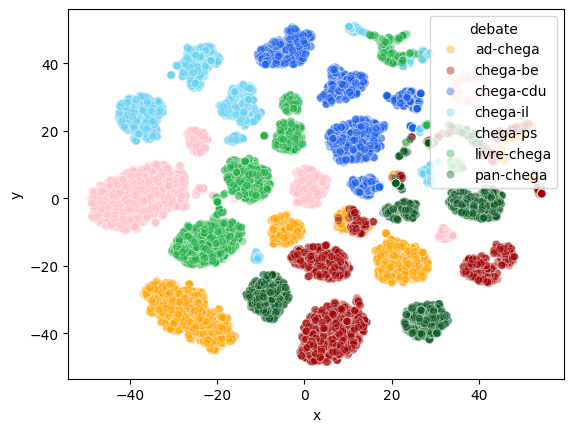

In [22]:
palette = {"ad-chega": "orange", "chega-be": "#A10000", "chega-cdu": "#1C5FED", "chega-il": "#67D3F4", "chega-ps": "pink", "pan-chega": "#0A5A21", "livre-chega": "#1EB145"}
# Assuming 'parties' is a list of your DataFrames, and 'party_names' is a list of the corresponding party names
data = df_dict['chega']
# Perform PCA
pca = PCA(n_components=70)
all_embedding = []
for embeddings in data['embedding']:
    all_embedding.append(embeddings)
all_embedding = np.array(all_embedding)
X = StandardScaler().fit_transform(all_embedding)
pca_result = pca.fit_transform(X)

# Perform t-SNE
tsne = TSNE(learning_rate=50)
tsne_results = tsne.fit_transform(pca_result)

# Create DataFrame for seaborn
df = pd.DataFrame()
df['x'] = tsne_results[:, 0]
df['y'] = tsne_results[:, 1]
df['debate'] = data['debate']
# Create scatter plot
sns.scatterplot(x='x', y='y', hue = 'debate', data=df, palette = palette, alpha=0.4)

plt.show()

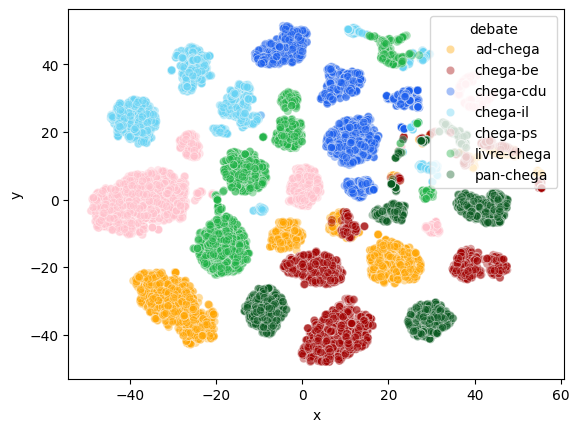

In [23]:
palette = {"ad-chega": "orange", "chega-be": "#A10000", "chega-cdu": "#1C5FED", "chega-il": "#67D3F4", "chega-ps": "pink", "pan-chega": "#0A5A21", "livre-chega": "#1EB145"}
# Assuming 'parties' is a list of your DataFrames, and 'party_names' is a list of the corresponding party names
data = df_dict['chega']
# Perform PCA
pca = PCA(n_components=70)
data['embeddings'] = data['fer'].apply(lambda lst: [d['embedding'] for d in lst if 'embedding' in d])
all_embeddings = []
for embeddings in data['embeddings']:
    all_embeddings.extend(embeddings)
all_embeddings = np.array(all_embeddings)
X = StandardScaler().fit_transform(all_embedding)
pca_result = pca.fit_transform(X)

# Perform t-SNE
tsne = TSNE(learning_rate=50)
tsne_results = tsne.fit_transform(pca_result)

# Create DataFrame for seaborn
df = pd.DataFrame()
df['x'] = tsne_results[:, 0]
df['y'] = tsne_results[:, 1]
df['debate'] = data['debate']
# Create scatter plot
sns.scatterplot(x='x', y='y', hue = 'debate', data=df, palette = palette, alpha=0.4)

plt.show()

#### Qualidade dos modelos para identificar pessoas na imagem

In [7]:
files = os.listdir('processed')
videos = [os.path.splitext(file)[0] for file in files]

pose_counts = {}
object_counts_person = {}
fer_counts = {}
total_frames = {}

for video in videos:
    data = pd.read_pickle('processed/' + video + '.pkl')
    
    pose_counts[video] = 0
    object_counts_person[video] = 0
    fer_counts[video] = 0
    total_frames[video] = len(data)
    
    for frame in range(len(data)):
        # Count poses
        pose_counts[video] += len(data.iloc[frame]['poses'])

        # Count detected objects labeled as persons
        object_counts_person[video] += sum(1 for obj in data.iloc[frame]['detections'] if obj[4] == 'person')

        # Count detected faces
        fer_counts[video] += len(data.iloc[frame]['fer'])
    
total_pose_counts = sum(pose_counts.values())
total_object_counts_person = sum(object_counts_person.values())
total_fer_counts = sum(fer_counts.values())
total_frames_count = sum(total_frames.values())

print("Total Pose Counts:", total_pose_counts)
print("Total Object Counts (person):", total_object_counts_person)
print("Total FER Counts:", total_fer_counts)
print("Total Frames Count:", total_frames_count)

Total Pose Counts: 79552
Total Object Counts (person): 120601
Total FER Counts: 131025
Total Frames Count: 58739


#### Dúvidas:
- Single video analysis - temos que analisar os videos a dedo?